In [15]:
import pandas as pd
from statistics import fmean as mean
from datetime import datetime, timedelta
import time
import requests
import base64
from urllib.parse import urlencode
import geopandas
from shapely.geometry import box
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import html, dcc, callback, Output, Input
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Classes imports

In [16]:
from spotify_data import Extractor

# Load data from .env file

In [17]:
# extract client id and secret from .env file
load_dotenv()
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
# create Extractor class object
data_extractor = Extractor(CLIENT_ID, CLIENT_SECRET)

# Data extraction
Defining analysed countries, extracting data using Spotify API and saving data to .csv file
Commented out cells are redundant after extracting data

In [18]:
countries_eu = [
  'AT', 'BE', 'BG', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'HR', 'IE', 'IT',
  'LV', 'LT', 'LU', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE'
]

In [19]:
# # find countries with dedicated Top 50 playlist
# countries_with_playlist = []
# for ct in countries_eu:
#   top50 = data_extractor.extract_top50_playlist('toplists', ct)
#   if top50 is not None:
#     countries_with_playlist.append(ct)
# countries = countries_with_playlist

In [20]:
countries_in_sample = [
  'AT', 'BE', 'BG', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IE', 'IT',
  'LV', 'LT', 'NL', 'PL', 'PT', 'RO', 'SK', 'ES', 'SE'
]
countries = countries_in_sample

In [21]:
# EU countries with dedicated Top 50 playlis
print(countries)

['AT', 'BE', 'BG', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'NL', 'PL', 'PT', 'RO', 'SK', 'ES', 'SE']


In [ ]:
# EU countries without dedicated Top 50 playlist
list(set(countries_eu)-set(countries))

['LU', 'HR', 'MT', 'SI', 'CY']

In [23]:
# # extract today's Top 50 playlists from EU countries
# data = data_extractor.extract_raw_data(countries)
# formatted_data = data_extractor.format_extracted_data(data)
# df = pd.DataFrame(formatted_data)
# # name dataset with currend day and month in format 'DD_MM.csv'
# filename = f"{datetime.strftime(datetime.now(), '%d')}_{datetime.strftime(datetime.now(), '%m')}.csv"
# # save dataset
# df.to_csv(filename)

# Data loading and preparation
Loading data and preparing it for analysis

In [24]:
# load all datasets used for analysis
df_1 = pd.read_csv('03_05.csv', index_col=0)
df_2 = pd.read_csv('13_05.csv', index_col=0)
df_3 = pd.read_csv('24_05.csv', index_col=0)

In [25]:
def convert_date(item):
  """
  Converts date in str format to date in datetime format

  Args:
    item: date in str format

  Returns:
    datetime object of str date
  """
  try:
    return datetime.strptime(item, '%Y-%m-%d')
  except ValueError:
    return datetime.strptime(item, '%Y')

In [26]:
def find_recent_songs(data, download_dates, exclude):
  """
  Finds songs that were released within 7 days of playlist DataFrame extraction

  Args:
    data: list of DataFrames
    download_dates: list of str format dates at witch DataFrames were extracted
    exclude: define if return is a list without recent songs or list with recent songs

  Returns:
    clean_list: list of DataFrame objects with most recent songs removed or containing only recent songs
  """
  clean_list=[]
  dates = [datetime.strptime(playlist_date, '%Y-%m-%d') for playlist_date in download_dates]
  for df, date in zip(data,dates):
    df = df.copy()
    df['release_date'] = df['release_date'].apply(lambda x: convert_date(x))
    if exclude:
      df = df[df['release_date'] < date - timedelta(days=7)]
    else:
      df = df[df['release_date'] > date - timedelta(days=7)]
    clean_list.append(df)
  return clean_list

In [27]:
def compute_means(countries, characteristics, datasets):
  """
  Compute means for given characteristics of countries present in every list of DataFrame object list

  Args:
    countries: list of analysed countries corresponding with country names in DataFrame object
    characteristics: characteristics which means are to be calculated
    datasets: list of DataFrame objects

  Returns:
    results: dict of means for every DataFrame object
  """
  results = {}

  for country in countries:
    results[country] = {}
    for item in characteristics:
      results[country][item] = []
      for dataset in datasets:
        results[country][item].append(mean(dataset[dataset['market'] == country][item].tolist()))
  return results

In [28]:
def extract_popularity_changes(recent_list, all_list_after):
  """
  Returns list of popularity values between playlists inside songs name dict inside country dict

  Args:
    recent_list: DataFrame of recent songs which popularity is to be analysed
    all_list_after: list of all DataFrames with songs that were collected after the recent_list DataFrame

  Returns:
    dict of popularity with corresponding song names and countries
  """
  popularity = {}
  # add global playlist to the country list
  for country in countries + ['GLOBAL']:
    # if country doesn't have any recents songs it is skipped
    if country not in recent_list['market'].tolist():
      continue

    popularity[country] = {}
    # add every recent song in given country to return dict
    for name in recent_list[recent_list['market']==country]['name'].tolist():
      popularity[country][name] = []
      # add initial popularity value to the value list
      popularity[country][name].append(recent_list[(recent_list['name']==name) & (recent_list['market'] == country)]['popularity'].item())
    # for every DataFrame of songs collected after recent_list
    for playlist in all_list_after:
      for name, values in popularity[country].items():
        # add popularity value if song is present in playlist
        try:
          popularity[country][name].append(playlist[(playlist['market'] == country) & (playlist['name'] == name)]['popularity'].item())
        # if song is not present in playlist skip it
        except ValueError:
          continue
  return popularity

In [29]:
# create list of DataFrames containing only local country songs (songs that are not present on Top 50 Global playlist)
local_songs_playlist = [data[~data['name'].isin(data[data['market']=='GLOBAL']['name'].tolist())] for data in [df_1, df_2, df_3]]

In [30]:
# create list of all playlists
all_playlist_list = [data for data in [df_1, df_2, df_3]]

In [31]:
# create list of dates at which playlist data was collected
download_dates = ['2023-05-03', '2023-05-13', '2023-05-24']
# remove songs released within 7 days before playlist download
local_songs_playlist = find_recent_songs(local_songs_playlist, download_dates, True)

In [32]:
# create list of DataFrame objects containing most recent songs in all playlist DataFrames
recent_songs = find_recent_songs(all_playlist_list, download_dates, False)

In [33]:
# create dict of recent song popularity changes
popularity_changes = extract_popularity_changes(recent_songs[0], all_playlist_list[1:])

In [34]:
# number of observations in popularity changes
TIMESPAN = 3

popularity_changes_clean = {}
for country, songs in popularity_changes.items():
  popularity_changes_clean[country] = {}
  for song, values in songs.items():
    # remove all songs that do not contain popularity changes between all three playlists
    if len(values) == TIMESPAN:
      popularity_changes_clean[country][song] = values

In [35]:
# remove all empty countries from dict
popularity_changes_clean = {k: v for k, v in popularity_changes_clean.items() if v}

# Graphical data analysis pt.1
Line plots and scatter plots

In [36]:
# list of colors corresponding to every country present in popularity_changes_clean dict
colors = ['red','blue','green','yellow','purple','pink','orange','brown','black','gray','bisque','gold','silver','navy','lightgray','lime','cyan','indigo','magenta','aqua']

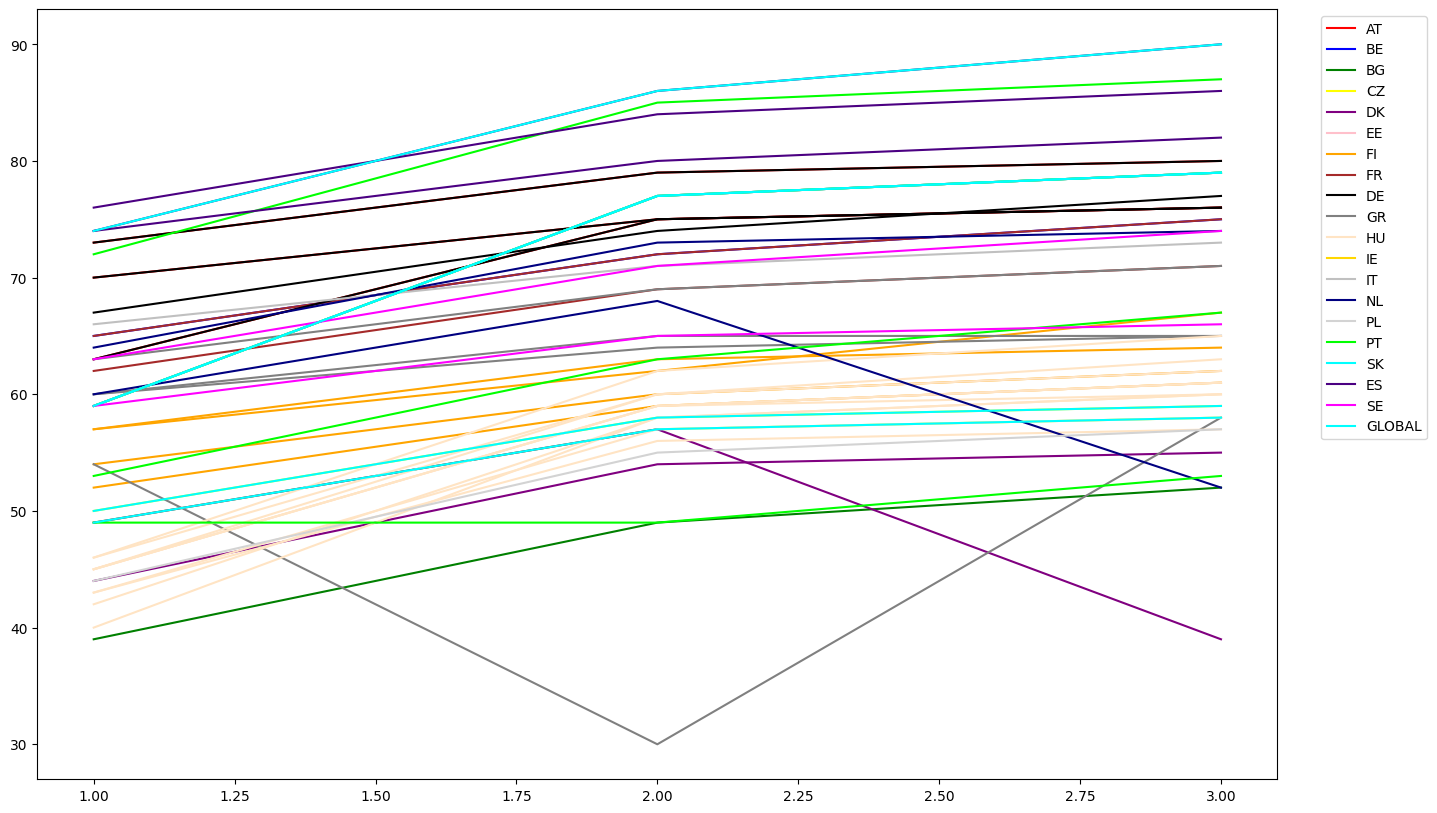

In [37]:
# create list of x values that corresponds with every popularity observation
x = [i+1 for i in range(TIMESPAN)]
# create list of country names that will be used to create label
label_names = [country for country,_ in popularity_changes_clean.items()]
# combine every country name with corresponding color
color_labels = list(zip(label_names, colors))
fig = plt.figure(figsize=(16,10))
for i,(country, songs) in enumerate(popularity_changes_clean.items()):
  for j, (song, values) in enumerate(songs.items()):
    # if this is a first observation for given country create country label
    if j == 0:
      plt.plot(x, values, label=color_labels[i][0], c=color_labels[i][1])
    # for every next observation only set corresponding color for given country
    else:
      plt.plot(x, values, c=color_labels[i][1])

# add legend outside the plot
plt.legend(bbox_to_anchor=(1.03, 1), loc="upper left")
# # save plot
# plt.savefig('popularity.png')
plt.show()

In [38]:
# create list of characteristics that are to be analysed
characteristics = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity']

# calculate mean values of given characteristics
results = compute_means(countries, characteristics, local_songs_playlist)

In [39]:
def get_average_of_characteristics(data, two_step_dict):
  """
  Computes average values of characteristics present in lists inside dict

  Args:
    data: dict of countries with characteristic mean value lists
    two_step_dict: defines if there is dict inside dict in supplied data

  Returns:
    averages: dict of average values
  """
  averages = {}
  for key,_ in data.items():
    averages[key] = {}
    if two_step_dict:
      for item, values_list in data[key].items():
        averages[key][item] = mean(values_list)
    else:
      averages[key] = mean(data[key])
  return averages

In [40]:
# create DataFrame object with average values of given characteristics for given country
df_averages = pd.DataFrame(get_average_of_characteristics(results, True))

In [41]:
market_share = {}
for country in countries:
  # calculate the market share of local songs in all analysed playlists
  market_share[country] = [len(item[item['market'] == country])/50 for item in local_songs_playlist]
# get average value of local songs market share
market_share = get_average_of_characteristics(market_share, False)
# add market_share characteristic to DataFrame
df_averages.loc['market_share'] = market_share

In [42]:
# # concatenate all analysed DataFrames
# concatenated_df = pd.concat([df_1, df_2, df_3])
#
# # create loop to check every combination of characteristics on scatter plot
# for i,characteristic_1 in enumerate(characteristics):
#   # if it is the last characteristic break the loop
#   if i == len(characteristics)-1:
#     break
#   # next loop starts at [i+1] characteristic to avoid duplicates and plots of same characteristic
#   for characteristic_2 in characteristics[i+1:]:
#     fig = plt.figure(figsize=(16,10))
#     plt.scatter(concatenated_df[characteristic_1], concatenated_df[characteristic_2], c='black')
#     # add axis labels
#     plt.xlabel(characteristic_1)
#     plt.ylabel(characteristic_2)
#     # save plot in dedicated folder
#     fig.savefig('scatters/{}-{}.png'.format(characteristic_1, characteristic_2))
#     # close the plot
#     plt.close(fig)

In [43]:
# add market_share to the list of analysed characteristics
characteristics.append('market_share')

In [44]:
# # save average values DataFrame to .csv file
# df_averages.to_csv('averages.csv')

In [45]:
# create DataFrame that will be used to plot data on map
df_averages_for_map = df_averages
df_averages_for_map = df_averages_for_map.transpose()

# Graphical data analysis pt.2
Plotting data on maps

In [46]:
# source of country polygon data: World Bank
world = geopandas.read_file('WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp')
# create box containing analysed countries
polygon = box(-25, 32, 40, 72)
# clip country polygon dataset to only contain area of interest
world_clipped = world.clip(polygon)

In [47]:
# remove redundant data
world_clipped.drop(['OBJECTID', 'featurecla', 'LEVEL', 'TYPE', 'FORMAL_EN', 'FORMAL_FR',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS','GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10_','ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'CONTINENT','REGION_UN', 'SUBREGION', 'REGION_WB', 'NAME_AR', 'NAME_BN', 'NAME_DE', 'NAME_ES', 'NAME_FR', 'NAME_EL', 'NAME_HI', 'NAME_HU','NAME_ID', 'NAME_IT', 'NAME_JA', 'NAME_KO', 'NAME_NL', 'NAME_PL','NAME_PT', 'NAME_RU', 'NAME_SV', 'NAME_TR', 'NAME_VI', 'NAME_ZH','WB_NAME', 'WB_RULES', 'WB_REGION'], axis=1, inplace=True)

In [48]:
# add ISO A2 code for France because for some reason it is not present in World Bank dataset
world_clipped.loc[20,'ISO_A2'] = 'FR'

In [49]:
# merge averages dataset and world polygons dataset
merged = pd.merge(world_clipped, df_averages_for_map, left_on=['ISO_A2'], right_on=[df_averages_for_map.index], how='outer')

In [50]:
# # for loop to create map plot of every characteristic
# for name, charact in characteristics_names.items():
#   fig, ax = plt.subplots(figsize=(30,10), subplot_kw=dict(aspect='equal'))
#   ax.axis('off')
#   divider = make_axes_locatable(ax)
#   cax = divider.append_axes("right", size="2.5%", pad=-2.5)
#   # plot countries not included in the analysis on map
#   merged.fillna(-1).plot(color='gray', ax=ax)
#   # plot countries included in the analysis
#   merged.dropna().fillna(-1).plot(column=charact[0],ax=ax, legend=True,cmap='autumn_r', cax=cax)
#   # add plot title
#   plt.title(name)
#   # save map plot in dedicated folder
#   plt.savefig(f'maps/{name}.png', dpi=300)
#   plt.close(fig)

# Dash app

In [51]:
# create dict of every characteristic name with corresponding list containing its name in dataset and description
characteristics_names = {'Acousticness':['acousticness','A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.'],
                         'Danceability':['danceability','Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.'],
                         'Duration in miliseconds':['duration_ms', 'The duration of the track in milliseconds.'],
                         'Energy':['energy', 'Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.'],
                         'Instrumentalness':['instrumentalness', 'Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.'],
                         'Liveness':['liveness', 'Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.'],
                         'Loudness':['loudness', 'The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.'],
                         'Speechiness':['speechiness', 'Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.'],
                         'Tempo':['tempo', 'The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.'],
                         'Valence':['valence', 'A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).'],
                         'Popularity':['popularity', 'The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.'],
                         'Market share':['market_share', 'Share of local songs in country Top 50 playlist (local means not present on Top 50 Global playlist)']}

In [56]:
# create JupyterDash app with location of stylesheet.css file
app = JupyterDash()

# set app layout
app.layout = html.Div(id='content_container', style={'font-family': 'Helvetica, Arial, sans-serif','background-color':'#1c1b29', 'text-align':'center', 'padding':'1em'}, children = [
  html.Div(id='title_container', style={'font-weight': 'bold','font-size': '2em','color': 'white'},
           children=[html.H2('Map of local songs characteristics in EU countries')]),
  html.Div(
    className='main_container', style={'width': '100%','padding-top': '2em','height-min': '5em','padding-bottom': '1em'},
    children=[
      html.Div(id='dropdown_container', style={'display': 'inline-block','position': 'relative','width': '20%','height': '5em'}, children=[
        dcc.Dropdown(options=list(characteristics_names.keys()),
                       value='Popularity',
                       id='dropdown_characteristic', style={'color': 'black','font-size': '16px','border': 'none','cursor': 'pointer'})
      ]),
      html.Div(id='characteristic_descr', style={'display': 'inline-block','color': 'white','background-color': 'black','border-radius': '10px','text-align': 'left','padding': '1em 0.5em 0.5em 3.6em','width': '75%','height': '5em','vertical-align':'top'})
    ]
  ),
  html.Div(
    className='graph_container', style={'width': '100%','background-color': 'black','border-radius': '10px','padding': '1em'},
    children=[
      dcc.Graph(figure={}, id='graph_canvas')
    ]
  )]
)

# define inputs and outputs
@callback(
  [Output(component_id='graph_canvas', component_property='figure'),
  Output(component_id='characteristic_descr', component_property='children')],
  Input(component_id='dropdown_characteristic', component_property='value')
)

# function to update plot and description
def update_graph(col_chosen):
  fig = px.choropleth(merged,geojson=merged.geometry,locations=merged.index,color=characteristics_names[col_chosen][0], hover_name=merged.NAME_EN, projection='natural earth')

  if col_chosen == 'Market share':
    desc = "Description: {}".format(characteristics_names[col_chosen][1])
  else:
    desc = "Offical spotify description: {}".format(characteristics_names[col_chosen][1])

  fig.update_geos(
      visible=True, resolution=50,fitbounds = 'locations'
  )
  fig.update_layout(
    coloraxis_colorbar=dict(
        title=col_chosen,
    )
  )
  fig.update_layout(paper_bgcolor="black")
  fig.update_layout(height=500, margin={"r":0,"t":10,"l":10,"b":10})
  return fig, desc

# run app
app.run_server(mode='external')

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/
